# Predicting location of hyperbolas 

In this Notebook we dive in on how to interact with the Yolo Model and extract the bounding boxes out of predictions. the Notebook is divided into following chapters

- Chapter 1: Load Yolo Model
- Chapter 2: Predicting Locations of Hyperbolas with YOLO Model
- Chapter 3: Extracting Bounding Boxes
- Chapter 5: Implementation in Pipeline



### Chapter 1: Load Yolo Model

First we load a Yolo Model we can do this directly threw the **ultralytics** Library.

In [1]:
#import libraries
import numpy as np
from ultralytics import YOLO

#Setting Working directory
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

#Import the config file so that only the Filename needs to be changed in the _read_segy function
from config import *




In [2]:
#Load trained Model
model = YOLO(YOLO_MODEL_DIR)


### Chapter 2: Predicting Locations of Hyperbolas with YOLO Model

for prediction we need Data. The idea is to take a sgy file and use the same code as when we created the images for training but now they are used as input for Training and expand the function a little. so what we do now is load the **DatatoolKit** an create a random test picture.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import segyio
import random

def create_images(df, file, inline:bool = False, crossline:bool = False, timeslice:bool= False, 
                        test_inline_random:bool = False, test_crossline_random:bool = False, test_timeslice_random:bool = False,
                        number_random_inlines:int = 1, number_random_crosslines:int = 1, number_random_timeslices:int = 1
                        ):
    
    outdir = TRAIN_DIR
    filename = df["filename"].iloc[0]

    bin_header = dict(file.bin)
    bin_header_dict = dict(bin_header)
    n_samples = int(bin_header_dict[segyio.BinField.Samples])

    inlines = sorted(df["inline"].unique())
    crosslines = sorted(df["crossline"].unique())

    il_map = {v: i for i, v in enumerate(inlines)}
    cl_map = {v: i for i, v in enumerate(crosslines)}

    if test_inline_random:
        inlines = random.sample(inlines, min(number_random_inlines, len(inlines)))
        outdir = TEST_PIC_DIR
    if test_crossline_random:
        crosslines = random.sample(crosslines, min(number_random_crosslines, len(crosslines)))
        outdir = TEST_PIC_DIR
    if test_timeslice_random:
        rand_timeslices = random.sample(range(n_samples), min(number_random_timeslices, n_samples))
        outdir = TEST_PIC_DIR
    else:
        rand_timeslices = range(n_samples)

    if inline:   
        for inline_nr in inlines:
            sub = df[df["inline"] == inline_nr].sort_values("crossline")
            img = np.vstack(sub["Amplitude"].values).T
            out_path = os.path.join(outdir, f"{filename}_inline_{inline_nr}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {len(inlines)} images to {out_path}")

    if crossline:
        
        for crossline_nr in crosslines:
            sub = df[df["crossline"] == crossline_nr].sort_values("inline")
            img = np.vstack(sub["Amplitude"].values).T
            out_path = os.path.join(outdir, f"{filename}_crossline_{crossline_nr}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {len(crosslines)} images to {out_path}")

    if timeslice:
        
        for sample_index in rand_timeslices:
            mat = np.full((len(inlines), len(crosslines)), np.nan)

            for _,row in df.iterrows():
                i = il_map[row["inline"]]
                j = cl_map[row["crossline"]]
                mat[i, j] = row["Amplitude"][sample_index]
        
            img = np.nan_to_num(mat)
            out_path=os.path.join(outdir, f"{filename}_timeslice_{sample_index}.png")
            plt.imsave(out_path, img, cmap="grey")
        
        print(f"saved {len(rand_timeslices)} images to {out_path}")






next step is to load the File

In [4]:
from Pipeline.Datatoolkit import DatatoolKit

dk = DatatoolKit(TEST_FILE_DIR , "UG3DQUERUNTERZUG.SGY")
file = dk.LoadSGY()
df = dk.create_df(file)

then we create a inline random test picture

In [5]:
create_images(df=df, 
              file=file,
              inline=True,
              test_inline_random=True,
              number_random_inlines=1)

saved 1 images to c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_18.png


as next step we can make a prediction

In [27]:
model.predict(TEST_PIC_DIR / "UG3DQUERUNTERZUG.SGY_inline_52.png",save =True, conf=0.1)


image 1/1 c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_52.png: 384x640 5 hyperbolas, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 10.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\pythonad\PAINDHS25\PAINDGPR\Notebooks\runs\detect\predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'hyperbola'}
 obb: None
 orig_img: array([[[100, 100, 100],
         [100, 100, 100],
         [101, 101, 101],
         ...,
         [115, 115, 115],
         [116, 116, 116],
         [117, 117, 117]],
 
        [[ 81,  81,  81],
         [ 80,  80,  80],
         [ 83,  83,  83],
         ...,
         [ 81,  81,  81],
         [ 83,  83,  83],
         [ 83,  83,  83]],
 
        [[ 68,  68,  68],
         [ 64,  64,  64],
         [ 65,  65,  65],
         ...,
         [ 48,  48,  48],
         [ 48,  48,  48],
         [ 48,  48,  48]],
 
        ...,
 
        [[168, 168, 168],
         [134, 134, 134],
         [ 52,  52,  52],
         ...,
         [195, 195, 195],
         [147, 147, 147],
         [147, 147, 147]],
 
        [[154, 154, 154],
         [ 87,  87,  87],
         [ 60,  60,  60],
         ...,
         [141, 

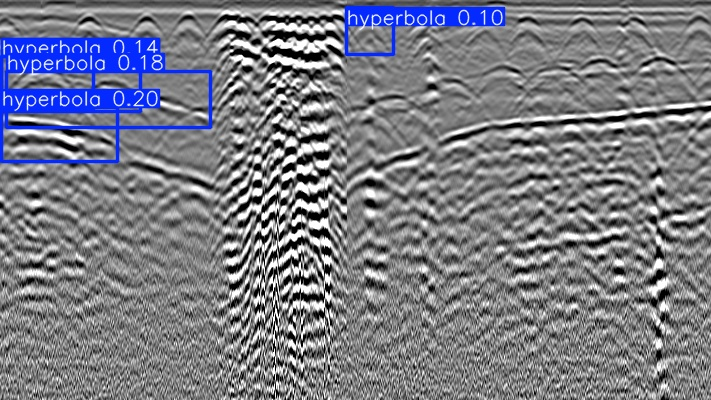

This is what our prediction looks like with the YOLO Model

## Chapter 3: Extracting Bounding Boxes

for further processing we need the Bounding boxes of the Image we predict. With Yolo it is fairyl simple to extract those bounding boxes. For that we implemend a function that does exactly thath. The idea it that it extract all bounding bounding boxes from all images where our predictions are saved. This function makes predictions and extracting bounding boxes simultaniously

In [6]:
def extract_bboxes(prediction_folder)-> list:
    results = model.predict(source=prediction_folder, save = True, conf=0.1)
    all_boxes = {}

    for result in results:
        img_name = os.path.basename(result.path)
        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()
            all_boxes[img_name] = boxes# Bounding boxes in (x1, y1, x2, y2) format
        else:
            all_boxes[img_name] = np.empty((0,4))       
        
    return all_boxes

In [7]:
boxes = extract_bboxes(TEST_PIC_DIR)


image 1/2 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_18.png: 384x640 5 hyperbolas, 103.8ms
image 2/2 c:\vscode\PAINDGPR\Data\Testdata\pictures\frame_0.jpg: 448x640 5 hyperbolas, 75.7ms
Speed: 2.4ms preprocess, 89.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to C:\vscode\PAINDGPR\Notebooks\runs\detect\predict


In [37]:
print(boxes)

{'UG3DQUERUNTERZUG.SGY_inline_52.png': array([[      1.137,      107.46,      117.34,      161.32],
       [     6.4071,      71.518,      210.26,      127.78],
       [     1.1274,      56.227,       93.03,      110.63],
       [      1.466,      56.229,      140.63,      111.66],
       [     346.46,      7.3693,      393.12,      54.333]], dtype=float32), 'UG3DQUERUNTERZUG.SGY_inline_59.png': array([[    0.16984,      11.065,      32.777,      55.192],
       [     508.71,      5.6568,       557.3,      50.618],
       [     561.52,      8.3862,      609.23,      50.604],
       [     1.4096,      104.31,      148.92,      164.06],
       [     1.8562,      56.717,      162.21,      106.66],
       [     612.34,      9.4982,      664.65,      50.352],
       [     675.03,      5.3894,         711,      53.813],
       [     62.903,      8.4614,      111.32,       56.05],
       [     401.13,      53.629,      650.72,      107.15]], dtype=float32), 'frame_0.jpg': array([[     151.06,